# Automatic road extraction from satellite images

## Imports

In [1]:
# Import the necessary libraries
import os
import sys
from pathlib import Path

In [2]:
# Provide path to helper functions contained inside the repository
current_file_path = os.path.abspath('')
root_file_path = str(Path(current_file_path).parent)
sys.path.append(root_file_path)

In [3]:
# Load the helper functions
from deep_globe_seg.helpers import list_subfolders_and_files, CFG, Dataset, get_preprocessing, get_training_augmentation, Dataloader, visualize_samples, plot_training_history

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.14 (you have 1.4.11). Upgrade using: pip install --upgrade albumentations
2024-08-18 17:02:15.668424: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# Import CV packages
import numpy as np
import pandas as pd
from pathlib import Path

# Import tensorflow, keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import CSVLogger

# Import image segmentation package
os.environ['SM_FRAMEWORK'] = "tf.keras"
import segmentation_models as sm

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

Segmentation Models: using `tf.keras` framework.


## Configuration and model set-up

In [5]:
# Define custom parameters
custom_dataset_params = {
    'img_size': (512, 512),
    'input_shape': (512, 512, 3),
}

custom_hyper_params = {
    'batch_size': 8,
    'learning_rate': 0.0001,
    'num_classes': 1,
    'epochs': 10
}

# Initialize the CFG class with custom parameters
configs = CFG(image_folder=os.path.join(root_file_path, 'data'),
                  saved_model_folder=os.path.join(root_file_path, 'saved_models'),
                  tensorboard_logs_path=os.path.join(root_file_path, 'logs'),
                  model_type='unet',
                  hyper_params= custom_hyper_params,
                  dataset_params= custom_dataset_params)

In [6]:
# Define U-Net model parameters
BACKBONE = 'resnet50'
BATCH_SIZE = configs.HyperParameter.batch_size
CLASSES = ['road']
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
LR = configs.HyperParameter.learning_rate
EPOCHS = configs.HyperParameter.epochs

In [7]:
# Create the necessary folders
Path(configs.Path.saved_model_folder).mkdir(parents = True, exist_ok = True)
Path(configs.Path.tensorboard_logs_path).mkdir(parents = True, exist_ok = True)

## Split data

In [8]:
# Display a sample of sub-folders and files
list_subfolders_and_files(configs.Path.image_folder)

Subfolder: /Users/sgpeytrignet/Documents/deepglobe-road-segmentation/data/valid
  100794_sat.jpg
  100905_sat.jpg
  102867_sat.jpg
  10417_sat.jpg
  106553_sat.jpg
  10678_sat.jpg
  107243_sat.jpg
  109245_sat.jpg
  11053_sat.jpg
  112600_sat.jpg
Subfolder: /Users/sgpeytrignet/Documents/deepglobe-road-segmentation/data/test
  100393_sat.jpg
  100995_sat.jpg
  101982_sat.jpg
  10206_sat.jpg
  102240_sat.jpg
  102765_sat.jpg
  104859_sat.jpg
  105342_sat.jpg
  105546_sat.jpg
  105695_sat.jpg
Subfolder: /Users/sgpeytrignet/Documents/deepglobe-road-segmentation/data/train
  100034_mask.png
  100034_sat.jpg
  100081_mask.png
  100081_sat.jpg
  100129_mask.png
  100129_sat.jpg
  100703_mask.png
  100703_sat.jpg
  100712_mask.png
  100712_sat.jpg


In [9]:
# Read metadata and filter for training data
metadata_df = pd.read_csv(configs.Path.metadata)
metadata_df = metadata_df[metadata_df['split'] == 'train']
metadata_df = metadata_df.iloc[:5000,:] # Limit the number of samples for faster training

# Select relevant columns and update paths
metadata_df = metadata_df[['image_id', 'sat_image_path', 'mask_path']]
metadata_df['sat_image_path'] = metadata_df['sat_image_path'].apply(lambda img_pth: os.path.join(configs.Path.image_folder, img_pth))
metadata_df['mask_path'] = metadata_df['mask_path'].apply(lambda mask_pth: os.path.join(configs.Path.image_folder, mask_pth))

# Shuffle DataFrame
metadata_df = metadata_df.sample(frac=1, random_state=9).reset_index(drop=True)

# Split into train, validation, and test sets (80/10/10 split)
test_df = metadata_df.sample(frac=0.1, random_state=9)
remaining_df = metadata_df.drop(test_df.index)
valid_df = remaining_df.sample(frac=0.1, random_state=9)
train_df = remaining_df.drop(valid_df.index)

# Print informative message about dataset split
print("Dataset successfully loaded and split into training, validation, and test sets:")
print(f"Number of samples in training set: {len(train_df)}")
print(f"Number of samples in validation set: {len(valid_df)}")
print(f"Number of samples in test set: {len(test_df)}")

Dataset successfully loaded and split into training, validation, and test sets:
Number of samples in training set: 41
Number of samples in validation set: 4
Number of samples in test set: 5


In [10]:
# Display the first few rows of the training DataFrame
train_df.head()

,image_id,sat_image_path,mask_path
0,103447,/Users/sgpeytrignet/Documents/deepglobe-road-s...,/Users/sgpeytrignet/Documents/deepglobe-road-s...
1,105553,/Users/sgpeytrignet/Documents/deepglobe-road-s...,/Users/sgpeytrignet/Documents/deepglobe-road-s...
3,10255,/Users/sgpeytrignet/Documents/deepglobe-road-s...,/Users/sgpeytrignet/Documents/deepglobe-road-s...
4,106523,/Users/sgpeytrignet/Documents/deepglobe-road-s...,/Users/sgpeytrignet/Documents/deepglobe-road-s...
5,100867,/Users/sgpeytrignet/Documents/deepglobe-road-s...,/Users/sgpeytrignet/Documents/deepglobe-road-s...


In [11]:
# Display the first few rows of the validation DataFrame
valid_df.head()

,image_id,sat_image_path,mask_path
43,105252,/Users/sgpeytrignet/Documents/deepglobe-road-s...,/Users/sgpeytrignet/Documents/deepglobe-road-s...
23,100892,/Users/sgpeytrignet/Documents/deepglobe-road-s...,/Users/sgpeytrignet/Documents/deepglobe-road-s...
8,105157,/Users/sgpeytrignet/Documents/deepglobe-road-s...,/Users/sgpeytrignet/Documents/deepglobe-road-s...
15,104,/Users/sgpeytrignet/Documents/deepglobe-road-s...,/Users/sgpeytrignet/Documents/deepglobe-road-s...


In [12]:
# Display the first few rows of the test DataFrame
test_df.head()

,image_id,sat_image_path,mask_path
21,106448,/Users/sgpeytrignet/Documents/deepglobe-road-s...,/Users/sgpeytrignet/Documents/deepglobe-road-s...
37,106147,/Users/sgpeytrignet/Documents/deepglobe-road-s...,/Users/sgpeytrignet/Documents/deepglobe-road-s...
2,100129,/Users/sgpeytrignet/Documents/deepglobe-road-s...,/Users/sgpeytrignet/Documents/deepglobe-road-s...
14,100703,/Users/sgpeytrignet/Documents/deepglobe-road-s...,/Users/sgpeytrignet/Documents/deepglobe-road-s...
44,104683,/Users/sgpeytrignet/Documents/deepglobe-road-s...,/Users/sgpeytrignet/Documents/deepglobe-road-s...


In [13]:
# Get class dictionary  
class_dict = pd.read_csv(configs.Path.class_dict)
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['road', 'background']
Class RGB values:  [[255, 255, 255], [0, 0, 0]]


## Initialize Dataset and Dataloader classes

In [14]:
# Load the pre-processing function for the chosen model
preprocess_input = sm.get_preprocessing(BACKBONE)

In [15]:
# Dataset for train images
train_dataset = Dataset(
    train_df,
    shape=configs.Dataset.img_size,
    classes=CLASSES,
    preprocessing=get_preprocessing(preprocess_input),
    augmentation=get_training_augmentation(configs.Dataset.img_size)
)

# Dataset for validation images
valid_dataset = Dataset(
    valid_df,
    shape=configs.Dataset.img_size,
    classes=CLASSES,
    preprocessing=get_preprocessing(preprocess_input)
)

# Dataset for test images
test_dataset = Dataset(
    test_df,
    shape=configs.Dataset.img_size,
    classes=CLASSES,
    preprocessing=get_preprocessing(preprocess_input)
)

# Dataloader for training and validation images
train_dataloader = Dataloader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloader(valid_dataset, batch_size=1, shuffle=False)
test_dataloader = Dataloader(test_dataset, batch_size=1, shuffle=False)

INFO:root:Initialized Dataset with 41 samples.
INFO:root:Initialized Dataset with 4 samples.
INFO:root:Initialized Dataset with 5 samples.


In [16]:
# Check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, *configs.Dataset.img_size, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, *configs.Dataset.img_size, n_classes)

## Visualize a sample of the data

In [17]:
# Sample images from training and validation sets
sample_training_images = [train_dataset[i] for i in range(4)]
sample_validation_images = [valid_dataset[i] for i in range(4)]

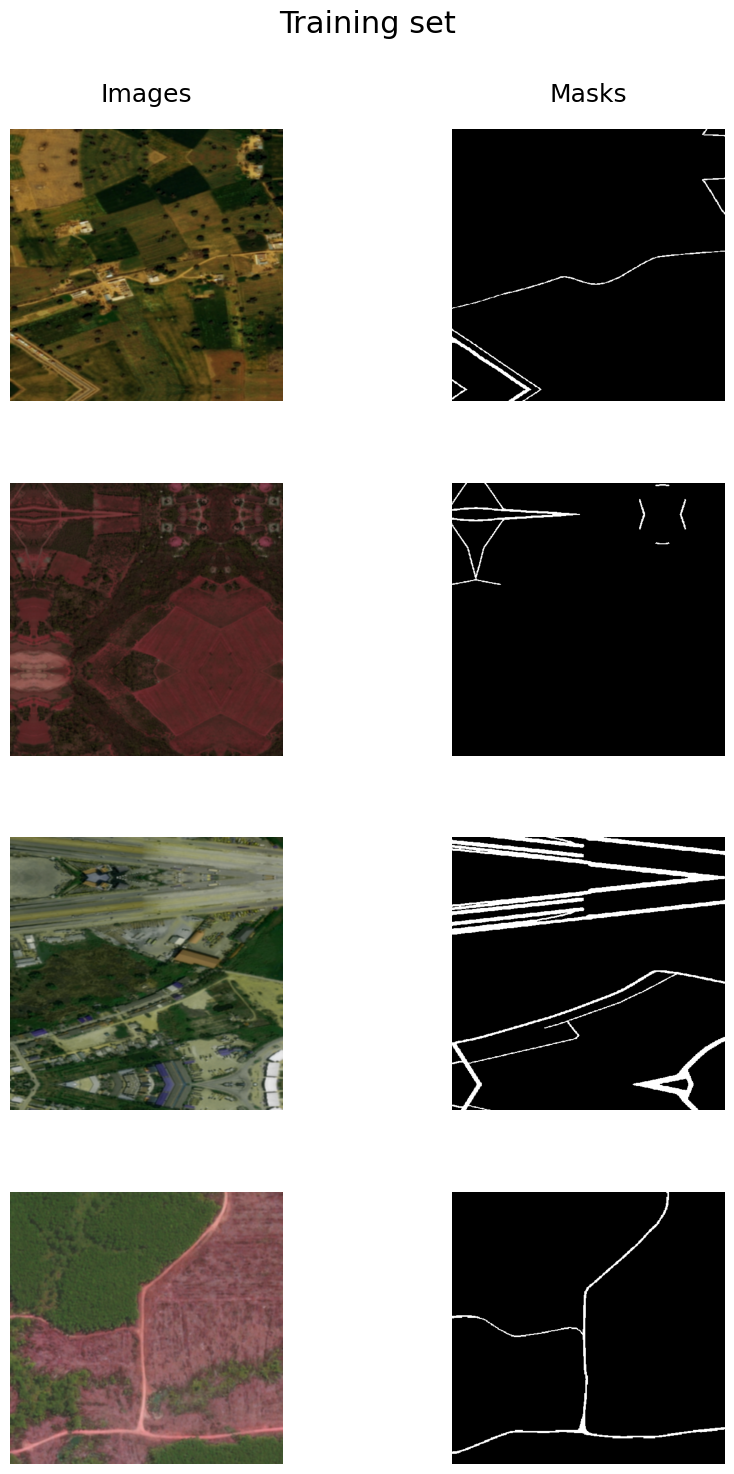

In [18]:
# Visualize training images
visualize_samples(sample_training_images, num_samples=5, figsize=(10, 3*5), figtitle="Training set")

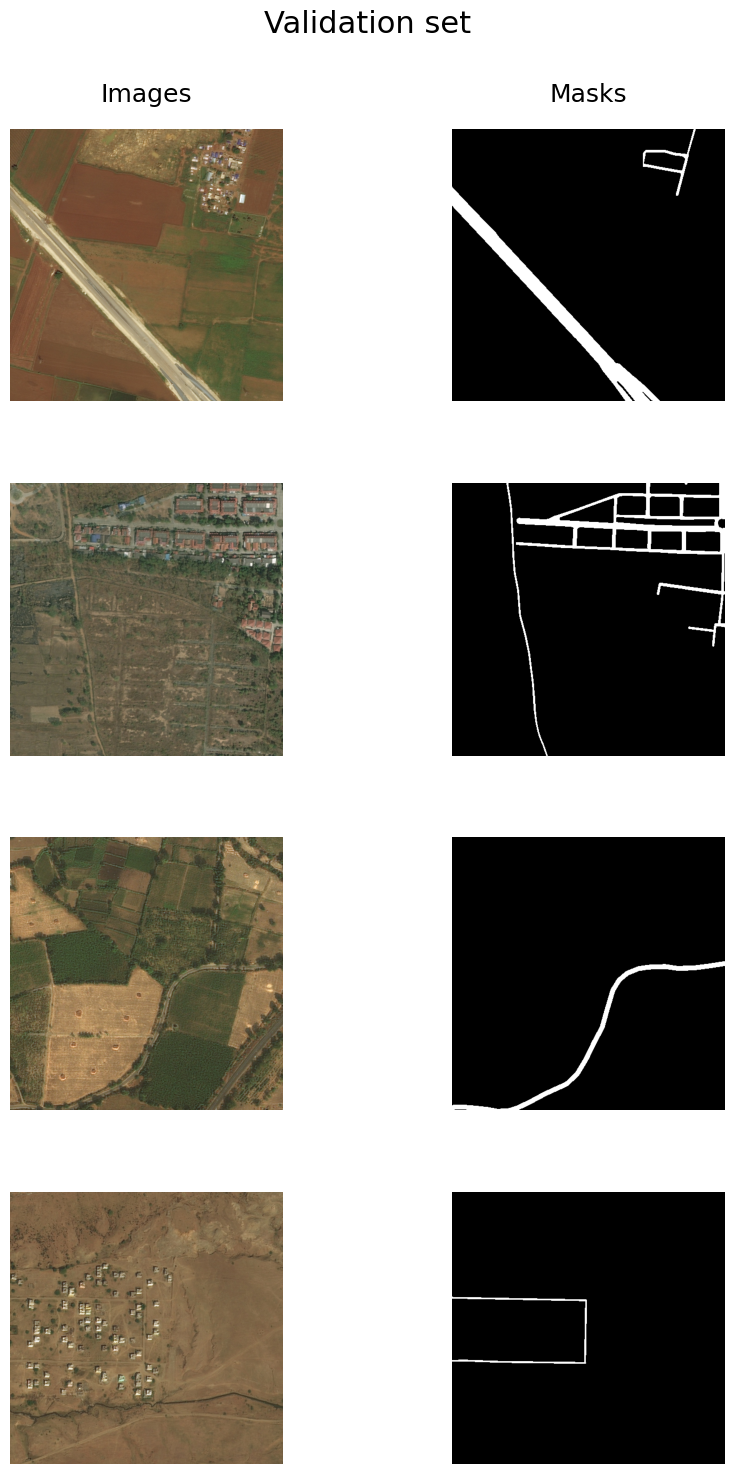

In [19]:
# Visualize validation images
visualize_samples(sample_validation_images, num_samples=5, figsize=(10, 3*5), figtitle="Validation set")

## Compile and fit U-net model

In [20]:
# Define network parameters
activation = 'sigmoid' if n_classes == 1 else 'softmax'

# Create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

In [21]:
# Define optomizer
optim = keras.optimizers.Adam(LR)

# Define loss function
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# Evaluation metrics
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
metrics_names = ["IOU","F"]

# Compile keras model with defined optimizer, loss and metrics inputs
model.compile(optimizer=optim, loss=total_loss, metrics=metrics)

In [22]:
# Define callbacks for learning rate scheduling, best checkpoints saving and log of training process
callbacks = [
    CSVLogger(os.path.join(configs.Path.tensorboard_logs_path,'training_log.csv'), append=True, separator=';'),
    keras.callbacks.ModelCheckpoint(configs.Path.model_save_path, save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.EarlyStopping(monitor='val_loss', 
                                  patience=3,
                                  verbose=1, 
                                  mode='min',
                                  restore_best_weights=True)
]

In [23]:
# Whether to train the model or load saved weights
run = False

In [24]:
# Train model
if run:
    if os.path.isfile(configs.Path.model_save_path):
        print("INFO ===========Running the Partially Trained Model===============")
        model.load_weights(configs.Path.model_save_path)
        history = model.fit(
            train_dataloader,
            epochs=EPOCHS,
            callbacks=callbacks, 
            validation_data=valid_dataloader,
            verbose=1
        )
    else:
        print("INFO ===========Running the Training of Model from Scratch===============")
        history = model.fit(
            train_dataloader, 
            epochs=EPOCHS,
            callbacks=callbacks, 
            validation_data=valid_dataloader,
            verbose=1
        )
else:
    print("INFO ===========Loading Pre-trained Model===============")

INFO ===========Loading Pre-trained Model===============


## Assess model scores

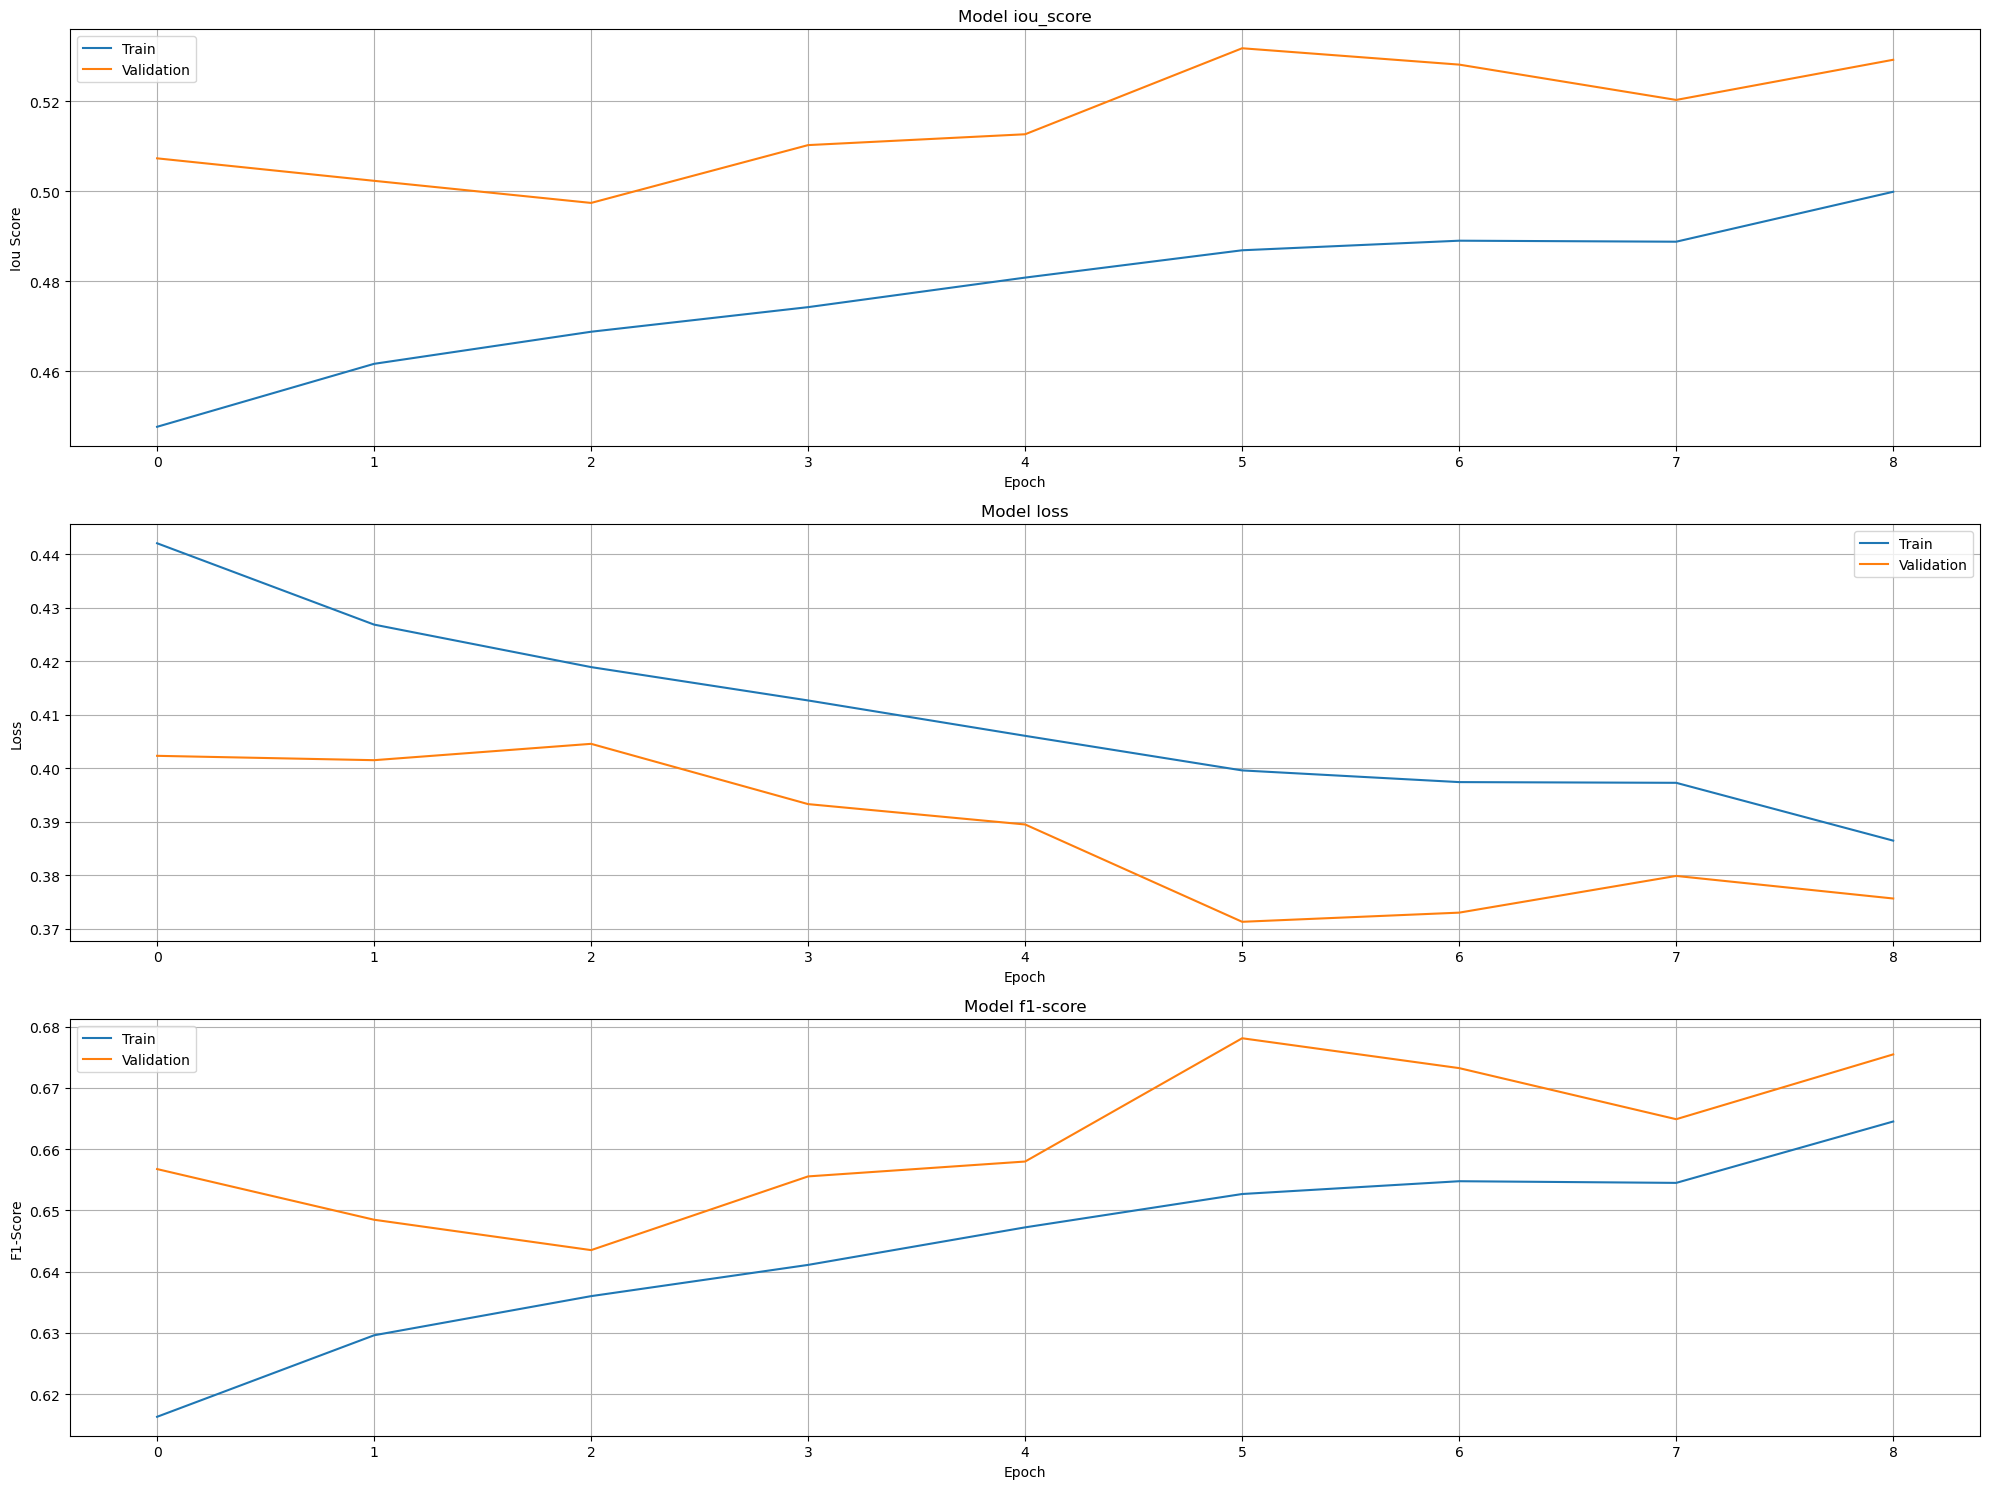

In [25]:
# Plot training history
if run:
    plot_training_history(history.history, ['iou_score', 'loss', 'f1-score'])
else:
    history = pd.read_csv(os.path.join(configs.Path.tensorboard_logs_path,'training_log.csv'), sep=',')
    plot_training_history(history, ['iou_score', 'loss', 'f1-score'])

In [26]:
# Load weights
if not run and os.path.isfile(configs.Path.model_save_path):
    model.load_weights(configs.Path.model_save_path) 

In [27]:
# Evaluate on the training set
train_results = model.evaluate(train_dataloader, verbose=1)

# Print the results
print("Training results:")
for metric_name, metric_value in zip(['loss'] + metrics_names, train_results):
    print(f"{metric_name}: {metric_value}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 102s 16s/step - f1-score: 0.6806 - iou_score: 0.5177 - loss: 0.3718
Training results:
loss: 0.3589992821216583
IOU: 0.5337363481521606
F: 0.6944370865821838


In [28]:
# Evaluate on the validation set
val_results = model.evaluate(valid_dataloader, verbose=1)

# Print the results
print("Validation results:")
for metric_name, metric_value in zip(['loss'] + metrics_names, val_results):
    print(f"{metric_name}: {metric_value}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - f1-score: 0.7663 - iou_score: 0.6328 - loss: 0.2785
Validation results:
loss: 0.34398308396339417
IOU: 0.5536925196647644
F: 0.6995827555656433


In [29]:
# Evaluate on the test set
test_results = model.evaluate(test_dataloader, verbose=1)

# Print the results
print("Test set results:")
for metric_name, metric_value in zip(['loss'] + metrics_names, test_results):
    print(f"{metric_name}: {metric_value}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - f1-score: 0.6181 - iou_score: 0.4971 - loss: 0.4199
Test set results:
loss: 0.41449299454689026
IOU: 0.49611788988113403
F: 0.6266947984695435


## Visualize predictions

In [30]:
# Generate test predictions
test_predictions = model.predict(test_dataloader, verbose=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step


In [31]:
# Prepare three layers for visualization
test_samples = [test_dataloader[i] for i in range(len(test_dataloader))]
test_images, test_masks = zip(*test_samples)
test_images = np.clip(tf.squeeze(test_images, axis=1).numpy(), 0, 255).astype(np.uint8)
test_masks = tf.squeeze(test_masks, axis=1).numpy()

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


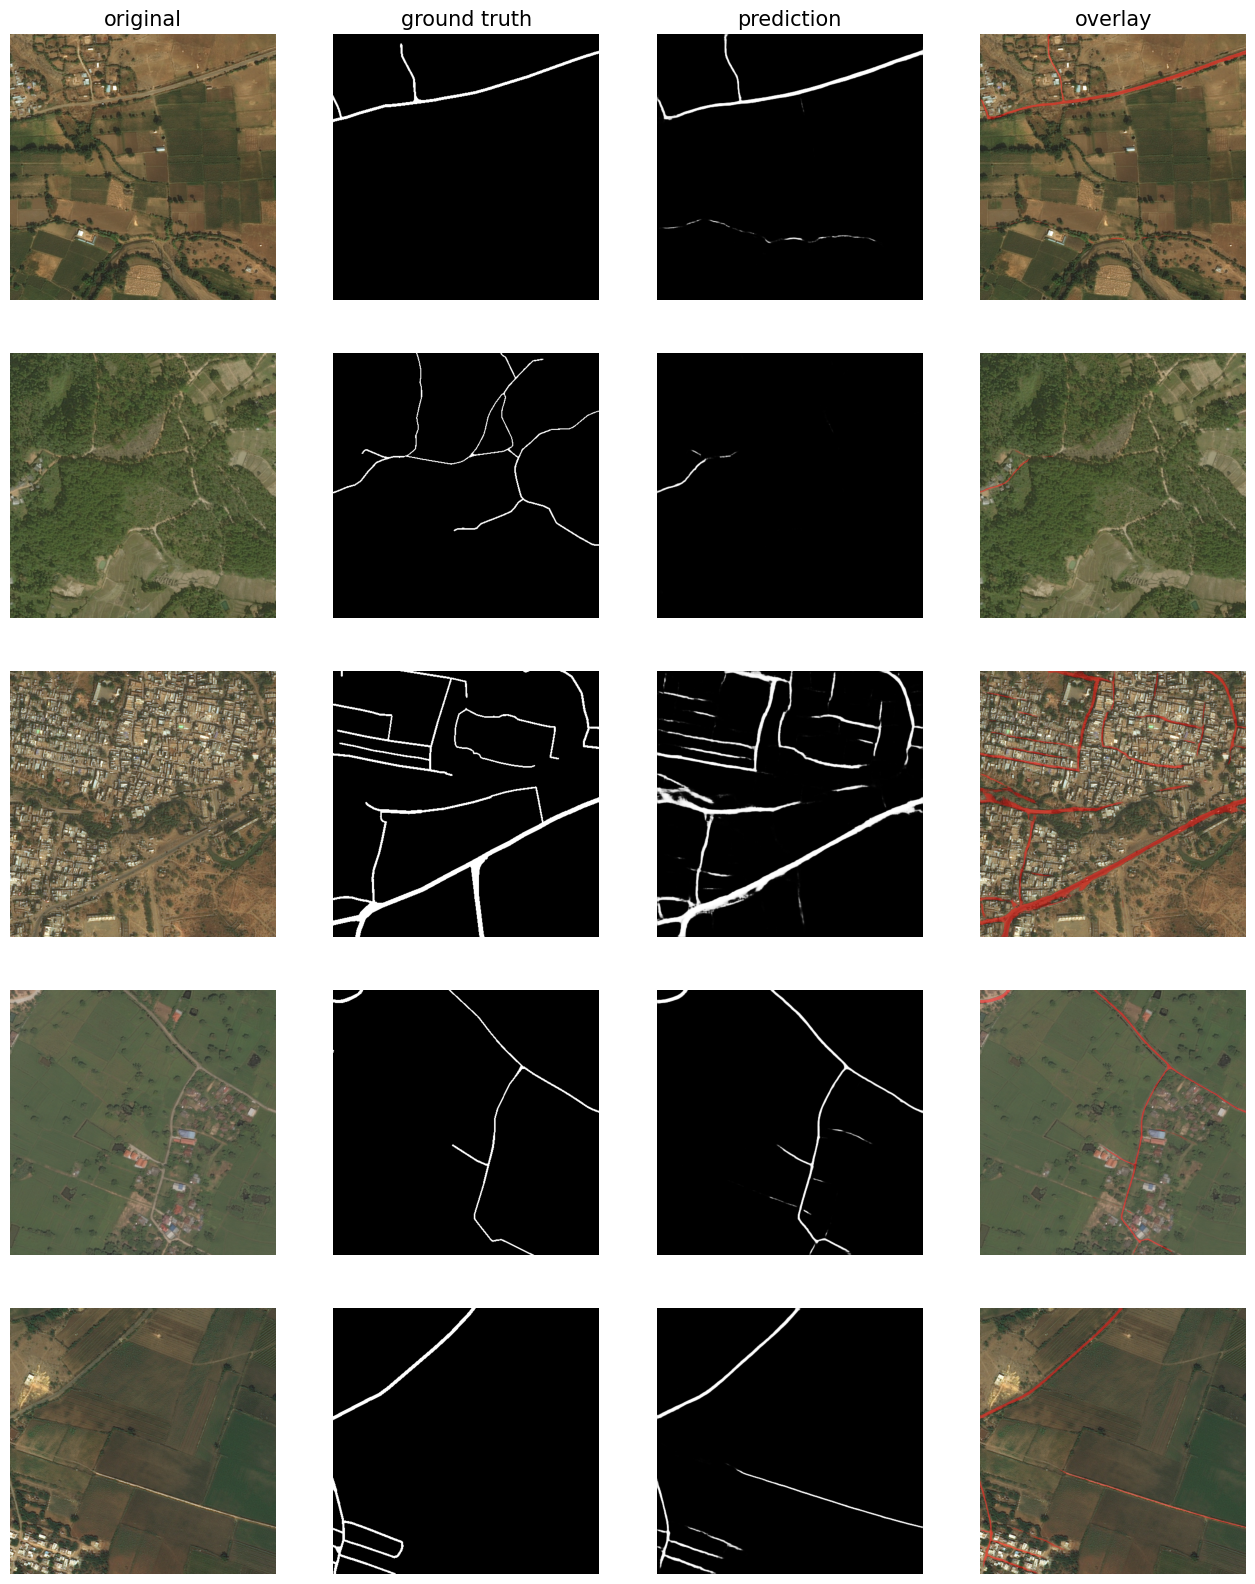

In [32]:
# Overlay original test images with predictions
from keras_unet.utils import plot_imgs
plot_imgs(org_imgs=test_images,
          mask_imgs=test_masks,
          pred_imgs=test_predictions, nm_img_to_plot=10)